### Question
Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import heapq


In [2]:
# Define the grid environment
class GridWorld:
    def __init__(self, size=100, obstacle_ratio=0.2):
        self.size = size
        self.grid = np.zeros((size, size))
        self.obstacle_ratio = obstacle_ratio
        self.start = None
        self.goal = None
        self.create_obstacles()
        self.set_start_goal()
    
    def create_obstacles(self):
        # Randomly place obstacles
        num_obstacles = int(self.size * self.size * self.obstacle_ratio)
        obstacles = random.sample([(i, j) for i in range(self.size) for j in range(self.size)], num_obstacles)
        for (i, j) in obstacles:
            self.grid[i][j] = -1  # Mark obstacles with -1
    
    def set_start_goal(self):
        # Set random start and goal positions ensuring they are not obstacles
        free_spaces = [(i, j) for i in range(self.size) for j in range(self.size) if self.grid[i][j] == 0]
        self.start = random.choice(free_spaces)
        free_spaces.remove(self.start)
        self.goal = random.choice(free_spaces)
        self.grid[self.start] = 1  # Mark start with 1
        self.grid[self.goal] = 2   # Mark goal with 2


In [3]:
env = GridWorld(size=100, obstacle_ratio=0.2)


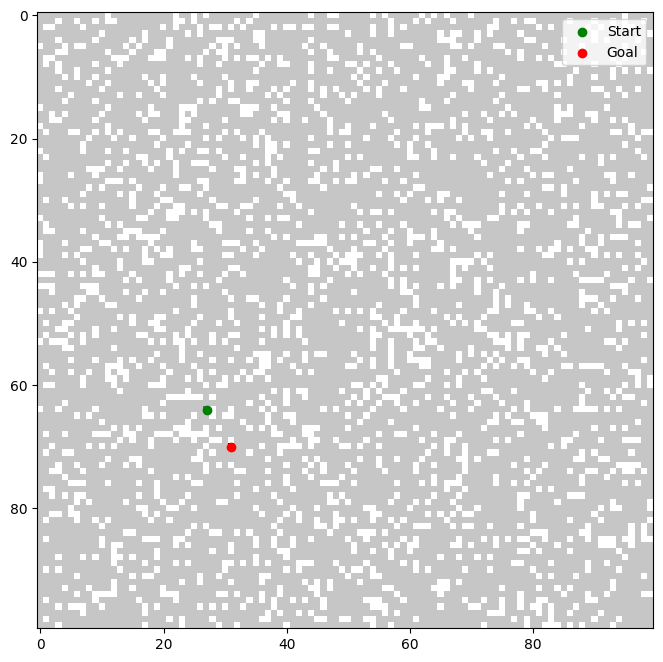

In [5]:
# Visualize the grid
def plot_grid(env):
    plt.figure(figsize=(8, 8))
    plt.imshow(env.grid, cmap='Greys', origin='upper')
    plt.scatter(env.start[1], env.start[0], c='green', label='Start')
    plt.scatter(env.goal[1], env.goal[0], c='red', label='Goal')
    plt.legend()
    plt.show()

plot_grid(env)


In [6]:
# Check if there is at least one valid path between start and goal using A*
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(env):
    start, goal = env.start, env.goal
    grid = env.grid
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while frontier:
        current = heapq.heappop(frontier)[1]
        
        if current == goal:
            return True  # Path found
        
        for delta in [(-1,0), (1,0), (0,-1), (0,1)]:
            neighbor = (current[0] + delta[0], current[1] + delta[1])
            if 0 <= neighbor[0] < env.size and 0 <= neighbor[1] < env.size:
                if grid[neighbor] == -1:
                    continue  # Skip obstacles
                new_cost = cost_so_far[current] + 1
                if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = new_cost
                    priority = new_cost + heuristic(goal, neighbor)
                    heapq.heappush(frontier, (priority, neighbor))
                    came_from[neighbor] = current
    return False  # No path found

# Ensure there's at least one valid path
while not a_star_search(env):
    env = GridWorld(size=100, obstacle_ratio=0.2)
    plot_grid(env)


In [7]:
# Define the MDP components
class MDPAgent:
    def __init__(self, env, discount_factor=0.99):
        self.env = env
        self.states = [(i, j) for i in range(env.size) for j in range(env.size) if env.grid[i][j] != -1]
        self.actions = ['up', 'down', 'left', 'right']
        self.discount_factor = discount_factor
        self.V = defaultdict(float)  # State-value function
        self.policy = {}
        self.rewards = self._initialize_rewards()
        self.transitions = self._initialize_transitions()
    
    def _initialize_rewards(self):
        rewards = {}
        for state in self.states:
            if state == self.env.goal:
                rewards[state] = 100  # High reward for goal
            else:
                rewards[state] = -1   # Negative reward for each move
        return rewards
    
    def _initialize_transitions(self):
        transitions = {}
        for state in self.states:
            transitions[state] = {}
            for action in self.actions:
                next_state = self._get_next_state(state, action)
                if next_state in self.states:
                    transitions[state][action] = next_state
                else:
                    transitions[state][action] = state  # If hit wall or obstacle, stay
        return transitions
    
    def _get_next_state(self, state, action):
        i, j = state
        if action == 'up':
            i -= 1
        elif action == 'down':
            i += 1
        elif action == 'left':
            j -= 1
        elif action == 'right':
            j += 1
        if 0 <= i < self.env.size and 0 <= j < self.env.size and self.env.grid[i][j] != -1:
            return (i, j)
        else:
            return state  # Return original state if move is invalid
    
    def value_iteration(self, theta=0.0001):
        while True:
            delta = 0
            for state in self.states:
                v = self.V[state]
                max_value = float('-inf')
                for action in self.actions:
                    next_state = self.transitions[state][action]
                    reward = self.rewards[next_state]
                    value = reward + self.discount_factor * self.V[next_state]
                    if value > max_value:
                        max_value = value
                self.V[state] = max_value
                delta = max(delta, abs(v - self.V[state]))
            if delta < theta:
                break
        # Derive policy
        for state in self.states:
            max_value = float('-inf')
            best_action = None
            for action in self.actions:
                next_state = self.transitions[state][action]
                reward = self.rewards[next_state]
                value = reward + self.discount_factor * self.V[next_state]
                if value > max_value:
                    max_value = value
                    best_action = action
            self.policy[state] = best_action


In [8]:
# Instantiate the MDP agent and perform value iteration
agent = MDPAgent(env)
agent.value_iteration()


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


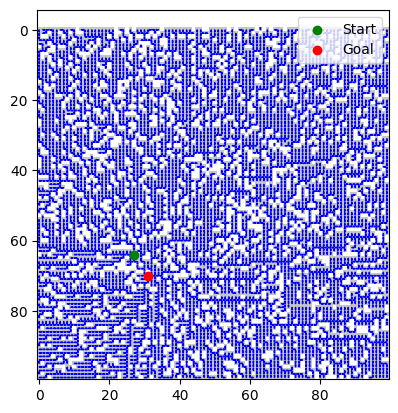

In [9]:
# Visualize the optimal policy
def plot_policy(agent):
    grid = np.copy(agent.env.grid)
    for state in agent.states:
        i, j = state
        action = agent.policy[state]
        if action == 'up':
            dx, dy = 0, -0.5
        elif action == 'down':
            dx, dy = 0, 0.5
        elif action == 'left':
            dx, dy = -0.5, 0
        elif action == 'right':
            dx, dy = 0.5, 0
        plt.arrow(j, i, dx, dy, head_width=0.2, head_length=0.2, fc='b', ec='b')
    plt.imshow(grid, cmap='Greys', origin='upper')
    plt.scatter(agent.env.start[1], agent.env.start[0], c='green', label='Start')
    plt.scatter(agent.env.goal[1], agent.env.goal[0], c='red', label='Goal')
    plt.legend()
    plt.show()

plot_policy(agent)


In [15]:
class QLearningAgent:
    def __init__(self, env, discount_factor=0.99, learning_rate=0.1, epsilon=0.1):
        self.env = env
        self.states = [(i, j) for i in range(env.size) for j in range(env.size) if env.grid[i][j] != -1]
        self.actions = ['up', 'down', 'left', 'right']
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: defaultdict(float))
        self.rewards = self._initialize_rewards()
    
    def _initialize_rewards(self):
        rewards = {}
        for state in self.states:
            if state == self.env.goal:
                rewards[state] = 100  # High reward for goal
            else:
                rewards[state] = -1   # Negative reward for each move
        return rewards

    def _get_next_state(self, state, action):
        i, j = state
        if action == 'up':
            i -= 1
        elif action == 'down':
            i += 1
        elif action == 'left':
            j -= 1
        elif action == 'right':
            j += 1
        # Check boundaries and obstacles
        if 0 <= i < self.env.size and 0 <= j < self.env.size and self.env.grid[i][j] != -1:
            return (i, j)
        else:
            return state  # Return original state if move is invalid

    def choose_action(self, state):
        q_values = self.Q[state]
        if not q_values or random.uniform(0, 1) < self.epsilon:
            # If Q-values are empty or exploring, choose a random action
            return random.choice(self.actions)
        else:
            max_q = max(q_values.values())
            actions_with_max_q = [action for action, q in q_values.items() if q == max_q]
            return random.choice(actions_with_max_q)

    def learn(self, episodes=1000, max_steps_per_episode=10000):
        for episode in range(episodes):
            state = self.env.start
            steps = 0
            while state != self.env.goal and steps < max_steps_per_episode:
                action = self.choose_action(state)
                next_state = self._get_next_state(state, action)
                reward = self.rewards[next_state]
                
                # Initialize Q-values for next_state if they don't exist
                if not self.Q[next_state]:
                    for a in self.actions:
                        self.Q[next_state][a] = 0.0
                
                # Q-Learning update
                max_next_q = max(self.Q[next_state].values())
                td_target = reward + self.discount_factor * max_next_q
                td_delta = td_target - self.Q[state][action]
                self.Q[state][action] += self.learning_rate * td_delta
                
                state = next_state
                steps += 1
            
            # Optional: Decay epsilon
            self.epsilon = max(0.01, self.epsilon * 0.995)
            
            # Optional: Print progress every 100 episodes
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{episodes} completed.")

            # Optional: Check if the agent reached the goal
            if state == self.env.goal:
                print(f"Goal reached in episode {episode + 1} after {steps} steps.")


In [16]:
# Instantiate the Q-Learning agent and learn
q_agent = QLearningAgent(env)
q_agent.learn(episodes=1000)


Goal reached in episode 1 after 7414 steps.
Goal reached in episode 2 after 342 steps.
Goal reached in episode 5 after 119 steps.
Goal reached in episode 6 after 489 steps.
Goal reached in episode 7 after 4989 steps.
Goal reached in episode 8 after 1052 steps.
Goal reached in episode 9 after 63 steps.
Goal reached in episode 11 after 41 steps.
Goal reached in episode 12 after 66 steps.
Goal reached in episode 13 after 728 steps.
Goal reached in episode 14 after 247 steps.
Goal reached in episode 18 after 91 steps.
Goal reached in episode 19 after 2117 steps.
Goal reached in episode 20 after 9991 steps.
Goal reached in episode 21 after 272 steps.
Goal reached in episode 24 after 34 steps.
Goal reached in episode 26 after 99 steps.
Goal reached in episode 27 after 286 steps.
Goal reached in episode 30 after 284 steps.
Goal reached in episode 32 after 106 steps.
Goal reached in episode 33 after 2007 steps.
Goal reached in episode 34 after 832 steps.
Goal reached in episode 35 after 3512 s

In [17]:
# Derive policy from Q-values
q_policy = {}
for state in q_agent.states:
    actions_q = q_agent.Q[state]
    if actions_q:
        best_action = max(actions_q, key=actions_q.get)
    else:
        best_action = random.choice(q_agent.actions)
    q_policy[state] = best_action


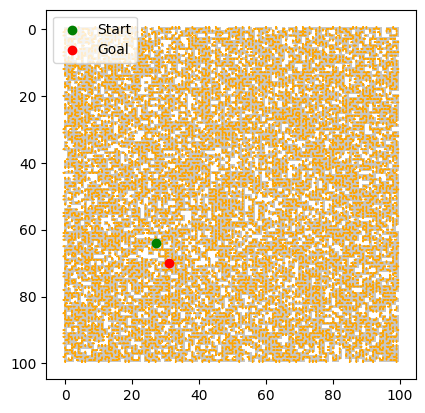

In [18]:
# Visualize the Q-Learning policy
def plot_q_policy(agent, policy):
    grid = np.copy(agent.env.grid)
    for state in agent.states:
        i, j = state
        action = policy[state]
        if action == 'up':
            dx, dy = 0, -0.5
        elif action == 'down':
            dx, dy = 0, 0.5
        elif action == 'left':
            dx, dy = -0.5, 0
        elif action == 'right':
            dx, dy = 0.5, 0
        plt.arrow(j, i, dx, dy, head_width=0.2, head_length=0.2, fc='orange', ec='orange')
    plt.imshow(grid, cmap='Greys', origin='upper')
    plt.scatter(agent.env.start[1], agent.env.start[0], c='green', label='Start')
    plt.scatter(agent.env.goal[1], agent.env.goal[0], c='red', label='Goal')
    plt.legend()
    plt.show()

plot_q_policy(q_agent, q_policy)


In [19]:
# Compare the policies
def compare_policies(agent1_policy, agent2_policy):
    same = 0
    total = len(agent1_policy)
    for state in agent1_policy:
        if agent1_policy[state] == agent2_policy[state]:
            same += 1
    print(f"Policies agree on {same}/{total} states, which is {same/total*100:.2f}%.")

compare_policies(agent.policy, q_policy)


Policies agree on 1701/8000 states, which is 21.26%.


In [21]:
def get_next_state(env, state, action):
    i, j = state
    if action == 'up':
        i -= 1
    elif action == 'down':
        i += 1
    elif action == 'left':
        j -= 1
    elif action == 'right':
        j += 1
    if 0 <= i < env.size and 0 <= j < env.size and env.grid[i][j] != -1:
        return (i, j)
    else:
        return state  # Return original state if move is invalid

# Evaluate policies by simulating episodes
def evaluate_policy(env, policy, episodes=100):
    total_steps = 0
    success_count = 0  # To track how many times the agent reaches the goal
    for _ in range(episodes):
        state = env.start
        steps = 0
        while state != env.goal and steps < 10000:
            action = policy.get(state, random.choice(['up', 'down', 'left', 'right']))
            next_state = get_next_state(env, state, action)
            # If the agent doesn't move, we can break to prevent infinite loops
            if next_state == state:
                steps += 1
                break
            state = next_state
            steps += 1
        if state == env.goal:
            success_count += 1
            total_steps += steps
        else:
            total_steps += steps  # You may choose to penalize or not count unsuccessful episodes
    if success_count > 0:
        avg_steps = total_steps / success_count
    else:
        avg_steps = float('inf')  # If the agent never reaches the goal
    return avg_steps, success_count

dp_avg_steps, dp_success_count = evaluate_policy(env, agent.policy)
q_avg_steps, q_success_count = evaluate_policy(env, q_policy)

print(f"DP Policy: Average steps to reach goal: {dp_avg_steps}, Success rate: {dp_success_count}%")
print(f"Q-Learning Policy: Average steps to reach goal: {q_avg_steps}, Success rate: {q_success_count}%")


DP Policy: Average steps to reach goal: 10.0, Success rate: 100%
Q-Learning Policy: Average steps to reach goal: 10.0, Success rate: 100%
